In [ ]:
# config

label = 'y'
metric = 'mean_absolute_error'
time_limit = 60*10
presets = 'best_quality'

do_drop_ds = True
# hour, dayofweek, dayofmonth, month, year
use_dt_attrs = []#["hour", "year"]
use_estimated_diff_attr = False
use_is_estimated_attr = True

use_groups = False
n_groups = 8

auto_stack = True
num_stack_levels = 1
num_bag_folds = 0
if auto_stack:
    num_stack_levels = None
    num_bag_folds = None

use_tune_data = False
use_test_data = True
tune_and_test_length = 24*30*3 # 3 months from end, this changes the evaluations for only test
holdout_frac = None
use_bag_holdout = False # Enable this if there is a large gap between score_val and score_test in stack models. 

sample_weight = None#'sample_weight' #None
weight_evaluation = False
sample_weight_estimated = 1 # this changes evaluations for test and tune WTF, cant find a fix

run_analysis = True

In [65]:
import pandas as pd
import numpy as np



import warnings
warnings.filterwarnings("ignore")


def feature_engineering(X):
    # shift all columns with "1h" in them by 1 hour, so that for index 16:00, we have the values from 17:00
    # but only for the columns with "1h" in the name
    #X_shifted = X.filter(regex="\dh").shift(-1, axis=1)
    #print(f"Number of columns with 1h in name: {X_shifted.columns}")


    columns = ['clear_sky_energy_1h:J', 'diffuse_rad_1h:J', 'direct_rad_1h:J',
       'fresh_snow_12h:cm', 'fresh_snow_1h:cm', 'fresh_snow_24h:cm',
       'fresh_snow_3h:cm', 'fresh_snow_6h:cm']
    
    X_shifted = X[columns].shift(-1, axis=0)

    # put the shifted columns back into the original dataframe
    X[columns] = X_shifted[columns]

    

    date_calc = None
    if "date_calc" in X.columns:
        date_calc = X[X.index.minute == 0]['date_calc']

    # resample to hourly
    X = X.resample('H').mean()

    if date_calc is not None:
        X['date_calc'] = date_calc

    return X




def fix_X(X, name):
    # Convert 'date_forecast' to datetime format and replace original column with 'ds'
    X['ds'] = pd.to_datetime(X['date_forecast'])
    X.drop(columns=['date_forecast'], inplace=True, errors='ignore')
    X.sort_values(by='ds', inplace=True)
    X.set_index('ds', inplace=True)

    
    X = feature_engineering(X)

    return X



def handle_features(X_train_observed, X_train_estimated, X_test, y_train):
    X_train_observed = fix_X(X_train_observed, "X_train_observed")
    X_train_estimated = fix_X(X_train_estimated, "X_train_estimated")
    X_test = fix_X(X_test, "X_test")


    # add sample weights, which are 1 for observed and 3 for estimated
    X_train_observed["sample_weight"] = 1
    X_train_estimated["sample_weight"] = sample_weight_estimated
    X_test["sample_weight"] = sample_weight_estimated


    y_train['ds'] = pd.to_datetime(y_train['time'])
    y_train.drop(columns=['time'], inplace=True)
    y_train.sort_values(by='ds', inplace=True)
    y_train.set_index('ds', inplace=True)

    return X_train_observed, X_train_estimated, X_test, y_train




def preprocess_data(X_train_observed, X_train_estimated, X_test, y_train, location):
    # convert to datetime
    X_train_observed, X_train_estimated, X_test, y_train = handle_features(X_train_observed, X_train_estimated, X_test, y_train)

    if use_estimated_diff_attr:
        X_train_observed["estimated_diff_hours"] = 0
        X_train_estimated["estimated_diff_hours"] = (X_train_estimated.index - pd.to_datetime(X_train_estimated["date_calc"])).dt.total_seconds() / 3600
        X_test["estimated_diff_hours"] = (X_test.index - pd.to_datetime(X_test["date_calc"])).dt.total_seconds() / 3600

        X_train_estimated["estimated_diff_hours"] = X_train_estimated["estimated_diff_hours"].astype('int64')
        # the filled once will get dropped later anyways, when we drop y nans
        X_test["estimated_diff_hours"] = X_test["estimated_diff_hours"].fillna(-50).astype('int64')
    
    if use_is_estimated_attr:
        X_train_observed["is_estimated"] = 0
        X_train_estimated["is_estimated"] = 1
        X_test["is_estimated"] = 1

    # drop date_calc
    X_train_estimated.drop(columns=['date_calc'], inplace=True)
    X_test.drop(columns=['date_calc'], inplace=True)


    y_train["y"] = y_train["pv_measurement"].astype('float64')
    y_train.drop(columns=['pv_measurement'], inplace=True)
    X_train = pd.concat([X_train_observed, X_train_estimated])
    

    # clip all y values to 0 if negative
    y_train["y"] = y_train["y"].clip(lower=0)
    
    X_train = pd.merge(X_train, y_train, how="inner", left_index=True, right_index=True)

    # print number of nans in sample_weight
    print(f"Number of nans in sample_weight: {X_train['sample_weight'].isna().sum()}")
    # print number of nans in y
    print(f"Number of nans in y: {X_train['y'].isna().sum()}")


    X_train["location"] = location
    X_test["location"] = location
    
    return X_train, X_test
# Define locations
locations = ['A', 'B', 'C']

X_trains = []
X_tests = []
# Loop through locations
for loc in locations:
    print(f"Processing location {loc}...")
    # Read target training data
    y_train = pd.read_parquet(f'{loc}/train_targets.parquet')
    
    # Read estimated training data and add location feature
    X_train_estimated = pd.read_parquet(f'{loc}/X_train_estimated.parquet')
    
    # Read observed training data and add location feature
    X_train_observed= pd.read_parquet(f'{loc}/X_train_observed.parquet')

    # Read estimated test data and add location feature
    X_test_estimated = pd.read_parquet(f'{loc}/X_test_estimated.parquet')

    # Preprocess data
    X_train, X_test = preprocess_data(X_train_observed, X_train_estimated, X_test_estimated, y_train, loc)

    X_trains.append(X_train)
    X_tests.append(X_test)

# Concatenate all data and save to csv
X_train = pd.concat(X_trains)
X_test = pd.concat(X_tests)



Processing location A...
Number of nans in sample_weight: 0
Number of nans in y: 0
Processing location B...
Number of nans in sample_weight: 0
Number of nans in y: 4
Processing location C...
Number of nans in sample_weight: 0
Number of nans in y: 6059


# Feature enginering

In [66]:
import numpy as np
import pandas as pd

X_train.dropna(subset=['y'], inplace=True)


for attr in use_dt_attrs:
    X_train[attr] = getattr(X_train.index, attr)
    X_test[attr] = getattr(X_test.index, attr)

print(X_train.head())




if use_groups:
    # fix groups for cross validation
    locations = X_train['location'].unique()  # Assuming 'location' is the name of the column representing locations

    grouped_dfs = []  # To store data frames split by location

    # Loop through each unique location
    for loc in locations:
        loc_df = X_train[X_train['location'] == loc]
        
        # Sort the DataFrame for this location by the time column
        loc_df = loc_df.sort_index()
        
        # Calculate the size of each group for this location
        group_size = len(loc_df) // n_groups
        
        # Create a new 'group' column for this location
        loc_df['group'] = np.repeat(range(n_groups), repeats=[group_size]*(n_groups-1) + [len(loc_df) - group_size*(n_groups-1)])
        
        # Append to list of grouped DataFrames
        grouped_dfs.append(loc_df)

    # Concatenate all the grouped DataFrames back together
    X_train = pd.concat(grouped_dfs)
    X_train.sort_index(inplace=True)
    print(X_train["group"].head())





to_drop = ["snow_drift:idx", "snow_density:kgm3"]

X_train.drop(columns=to_drop, inplace=True)
X_test.drop(columns=to_drop, inplace=True)

X_train.to_csv('X_train_raw.csv', index=True)
X_test.to_csv('X_test_raw.csv', index=True)

                     absolute_humidity_2m:gm3  air_density_2m:kgm3  \
ds                                                                   
2019-06-02 22:00:00                     7.700              1.22825   
2019-06-02 23:00:00                     7.700              1.22350   
2019-06-03 00:00:00                     7.875              1.21975   
2019-06-03 01:00:00                     8.425              1.21800   
2019-06-03 02:00:00                     8.950              1.21800   

                     ceiling_height_agl:m  clear_sky_energy_1h:J  \
ds                                                                 
2019-06-02 22:00:00           1728.949951               0.000000   
2019-06-02 23:00:00           1689.824951               0.000000   
2019-06-03 00:00:00           1563.224976               0.000000   
2019-06-03 01:00:00           1283.425049            1845.375000   
2019-06-03 02:00:00           1003.500000           56387.898438   

                     clear_sky_r

In [67]:
from autogluon.tabular import TabularDataset, TabularPredictor
from autogluon.timeseries import TimeSeriesDataFrame
import numpy as np
train_data = TabularDataset('X_train_raw.csv')
# set group column of train_data be increasing from 0 to 7 based on time, the first 1/8 of the data is group 0, the second 1/8 of the data is group 1, etc.
train_data['ds'] = pd.to_datetime(train_data['ds'])
train_data = train_data.sort_values(by='ds')

# # print size of the group for each location
# for loc in locations:
#     print(f"Location {loc}:")
#     print(train_data[train_data["location"] == loc].groupby('group').size())


# get end date of train data and subtract 3 months
split_time = pd.to_datetime(train_data["ds"]).max() - pd.Timedelta(hours=tune_and_test_length)
train_set = TabularDataset(train_data[train_data["ds"] < split_time])
test_set = TabularDataset(train_data[train_data["ds"] >= split_time])
if use_groups:
    test_set = test_set.drop(columns=['group'])

if do_drop_ds:
    train_set = train_set.drop(columns=['ds'])
    test_set = test_set.drop(columns=['ds'])
    train_data = train_data.drop(columns=['ds'])


def normalize_sample_weights_per_location(df):
    for loc in locations:
        loc_df = df[df["location"] == loc]
        loc_df["sample_weight"] = loc_df["sample_weight"] / loc_df["sample_weight"].sum() * loc_df.shape[0]
        df[df["location"] == loc] = loc_df
    return df

tuning_data = None
if use_tune_data:
    train_data = train_set
    if use_test_data:
        # split test_set in half, use first half for tuning
        tuning_data, test_data = [], []
        for loc in locations:
            loc_test_set = test_set[test_set["location"] == loc]
            loc_tuning_data = loc_test_set.iloc[:len(loc_test_set)//2]
            loc_test_data = loc_test_set.iloc[len(loc_test_set)//2:]
            tuning_data.append(loc_tuning_data)
            test_data.append(loc_test_data)
        tuning_data = pd.concat(tuning_data)
        test_data = pd.concat(test_data)
        print("Shapes of tuning and test", tuning_data.shape[0], test_data.shape[0], tuning_data.shape[0] + test_data.shape[0])

    else:
        tuning_data = test_set
        print("Shape of tuning", tuning_data.shape[0])
    
    # ensure sample weights for your tuning data sum to the number of rows in the tuning data.
    tuning_data = normalize_sample_weights_per_location(tuning_data)

    
else:
    if use_test_data:
        train_data = train_set
        test_data = test_set
        print("Shape of test", test_data.shape[0])

# ensure sample weights for your training (or tuning) data sum to the number of rows in the training (or tuning) data. 
train_data = normalize_sample_weights_per_location(train_data)
if use_test_data:
    test_data = normalize_sample_weights_per_location(test_data)

Loaded data from: X_train_raw.csv | Columns = 48 / 48 | Rows = 93023 -> 93023


Shape of test 5791


**`train_data` dataset summary**

,count,unique,top,freq,mean,std,min,25%,50%,75%,max,dtypes,missing_count,missing_ratio,raw_type,variable_type,special_types
absolute_humidity_2m:gm3,87160,757,,,6.138632,2.73761,0.5,4.1,5.6,8.0,17.35,float64,72,0.000825,float,numeric,
air_density_2m:kgm3,87160,1370,,,1.253802,0.036657,1.13925,1.22875,1.2525,1.27675,1.441,float64,72,0.000825,float,numeric,
ceiling_height_agl:m,72139,59833,,,2864.542561,2531.428872,27.8,1085.2625,1859.4751,3925.32485,12285.775,float64,15093,0.173021,float,numeric,
clear_sky_energy_1h:J,87160,48338,,,518229.586128,826472.503147,0.0,0.0,10285.9125,782695.7625,3000638.2,float64,72,0.000825,float,numeric,
clear_sky_rad:W,87160,19511,,,143.951884,230.149085,0.0,0.0,1.6,216.2,835.65,float64,72,0.000825,float,numeric,
cloud_base_agl:m,81279,61233,,,1736.160546,1797.954658,27.8,598.2875,1178.425,2081.0375,11673.725,float64,5953,0.068243,float,numeric,
dew_or_rime:idx,87160,9,,,0.009491,0.234376,-1.0,0.0,0.0,0.0,1.0,float64,72,0.000825,float,category,
dew_point_2m:K,87160,2001,,,275.537267,6.846723,247.425,271.0,275.4,280.8,293.625,float64,72,0.000825,float,numeric,
diffuse_rad:W,87160,10980,,,39.210491,60.603659,0.0,0.0,0.875,64.325,334.75,float64,72,0.000825,float,numeric,
diffuse_rad_1h:J,87160,48388,,,141157.599079,215626.031812,0.0,0.0,10242.1125,230609.79,1198506.0,float64,72,0.000825,float,numeric,


**`test_data` dataset summary**

,count,unique,top,freq,mean,std,min,25%,50%,75%,max,dtypes,missing_count,missing_ratio,raw_type,variable_type,special_types
absolute_humidity_2m:gm3,5791,289,,,4.192639,1.300644,1.1,3.35,4.3,5.05,7.7,float64,,,float,numeric,
air_density_2m:kgm3,5791,640,,,1.280018,0.024372,1.219,1.26375,1.279,1.29375,1.37175,float64,,,float,numeric,
ceiling_height_agl:m,4395,4247,,,3278.267059,2590.751931,27.925,1149.0625,2618.95,4661.025,12294.901,float64,1396,0.241064,float,numeric,
clear_sky_energy_1h:J,5791,3236,,,468868.613513,687198.257932,0.0,0.0,16407.477,790376.63,2551642.2,float64,,,float,numeric,
clear_sky_rad:W,5791,2046,,,130.246477,191.578221,0.0,0.0,2.675,221.925,710.5,float64,,,float,numeric,
cloud_base_agl:m,4934,4719,,,1733.271034,1987.046511,27.5,525.4375,904.825,2014.962525,10674.3,float64,857,0.147988,float,numeric,
dew_or_rime:idx,5791,9,,,-0.033716,0.233147,-1.0,0.0,0.0,0.0,1.0,float64,,,float,category,
dew_point_2m:K,5791,948,,,270.733081,4.634046,255.05,268.33749,271.6,273.9,280.4,float64,,,float,numeric,
diffuse_rad:W,5791,2237,,,42.175259,59.158733,0.0,0.0,1.775,78.4875,311.95,float64,,,float,numeric,
diffuse_rad_1h:J,5791,3244,,,151794.400875,209954.932718,0.0,0.0,18502.375,279034.95,1089341.6,float64,,,float,numeric,


### Feature Distance

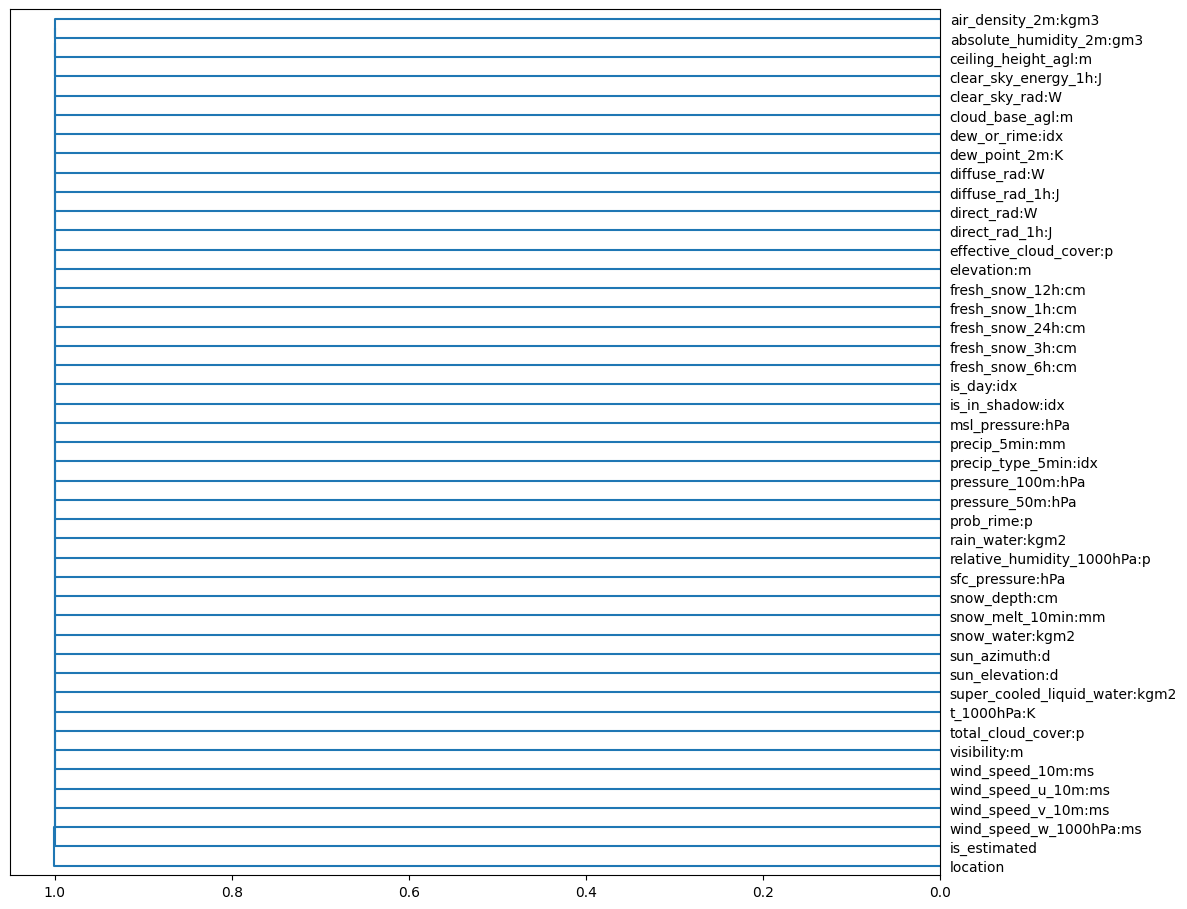

In [68]:
if run_analysis:
    import autogluon.eda.auto as auto
    auto.dataset_overview(train_data=train_data, test_data=test_data, label="y", sample=None)

## Target variable analysis

,count,mean,std,min,25%,50%,75%,max,dtypes,unique,missing_count,missing_ratio,raw_type,special_types
y,10000,299.128516,787.495283,-0.0,0.0,0.0,183.7125,5596.36,float64,2419,,,float,


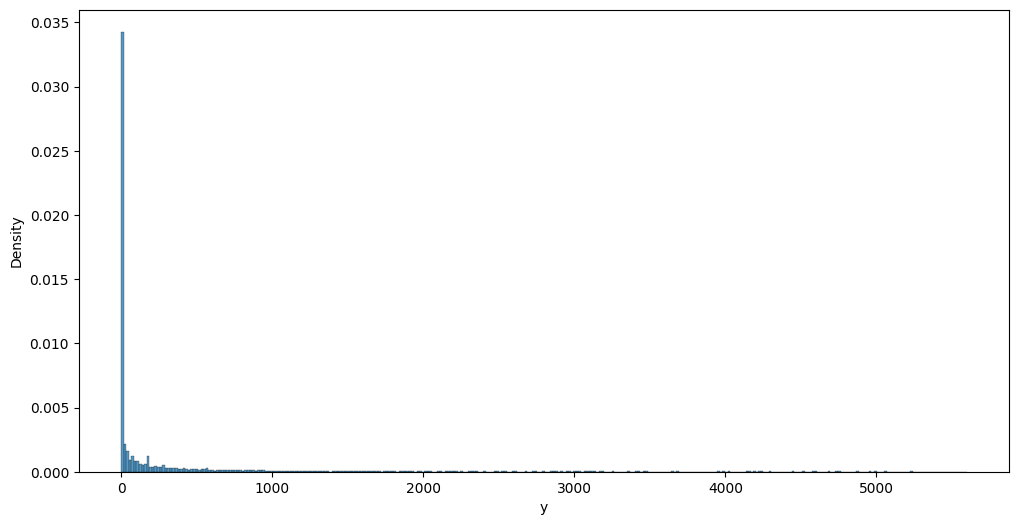

### Distribution fits for target variable
 - ⚠️ none of the [attempted](https://docs.scipy.org/doc/scipy/reference/stats.html#continuous-distributions) distribution fits satisfy specified minimum p-value threshold: `0.01`

### Target variable correlations

**`train_data` - `spearman` correlation matrix; focus: absolute correlation for `y` >= `0.5` (sample size: 10000)**

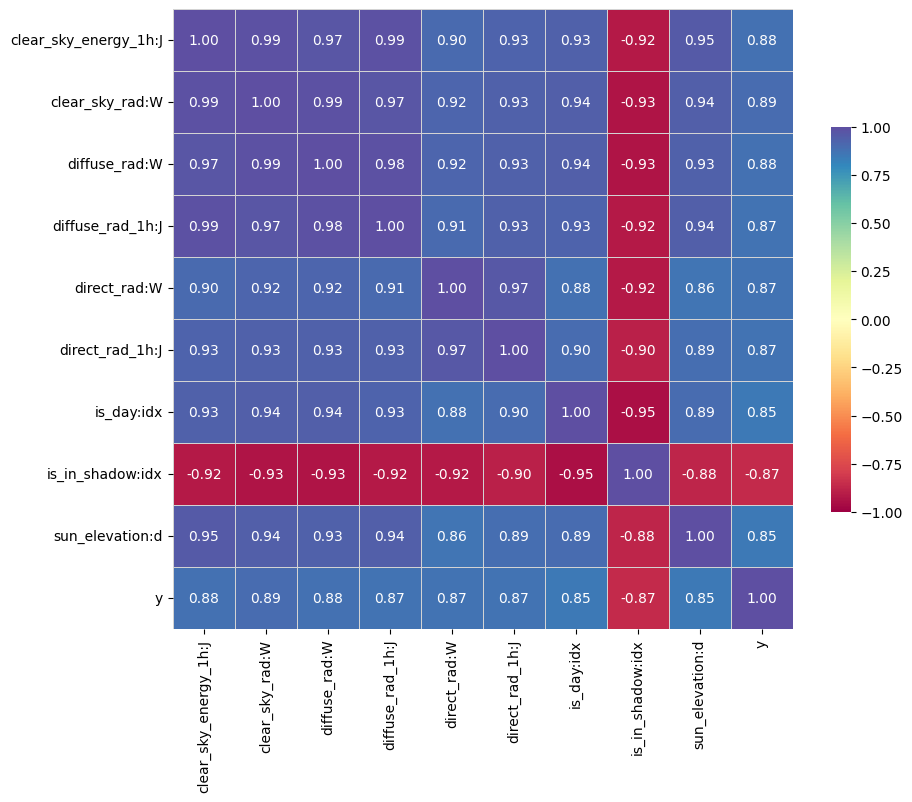

**Feature interaction between `clear_sky_rad:W`/`y` in `train_data` (sample size: 10000)**

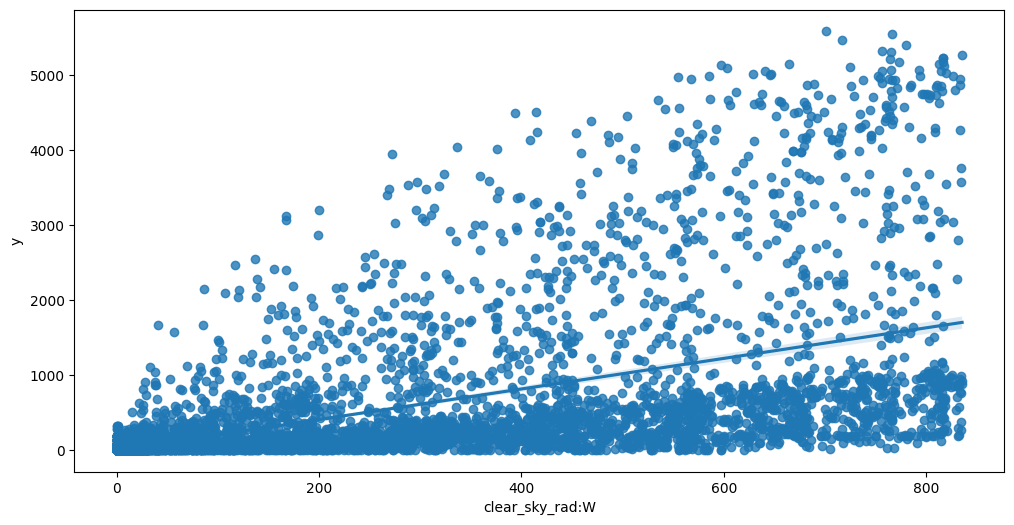

**Feature interaction between `diffuse_rad:W`/`y` in `train_data` (sample size: 10000)**

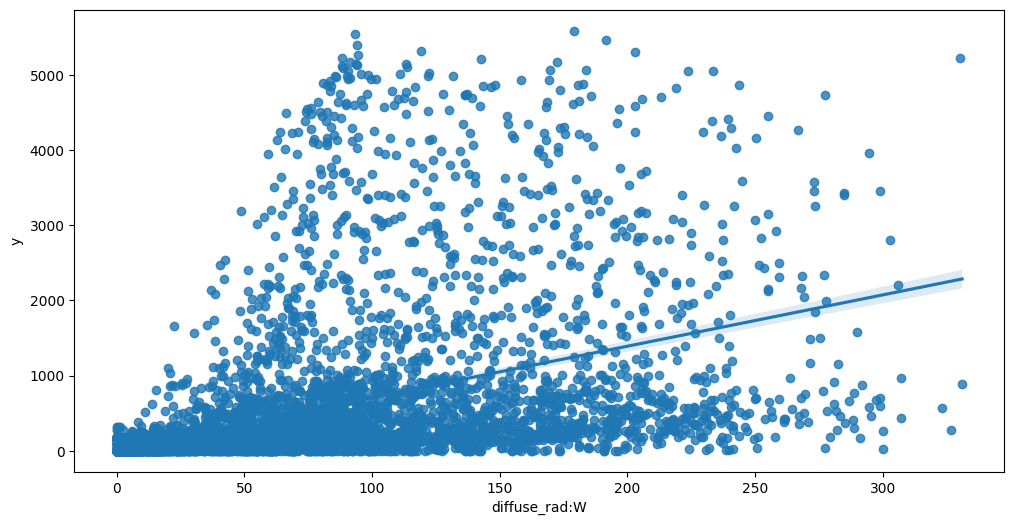

**Feature interaction between `clear_sky_energy_1h:J`/`y` in `train_data` (sample size: 10000)**

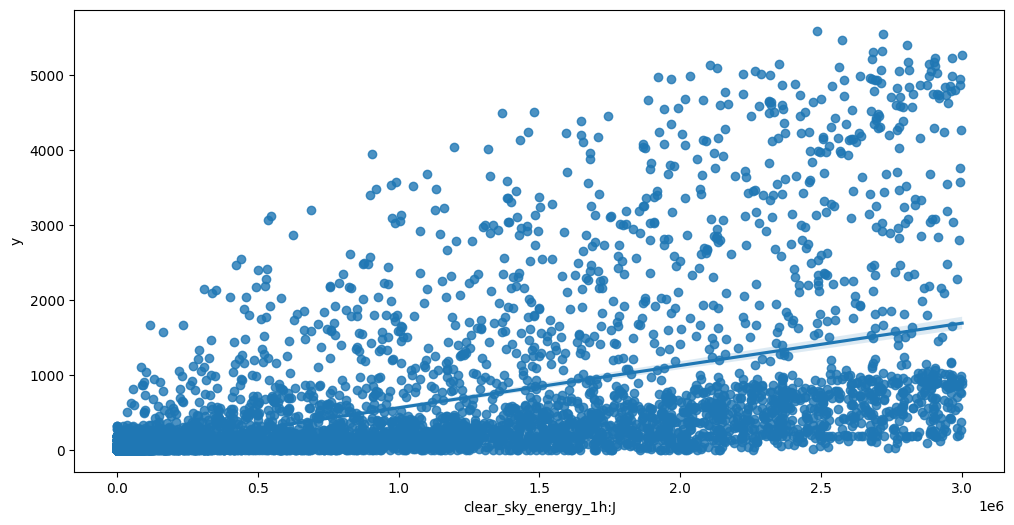

**Feature interaction between `diffuse_rad_1h:J`/`y` in `train_data` (sample size: 10000)**

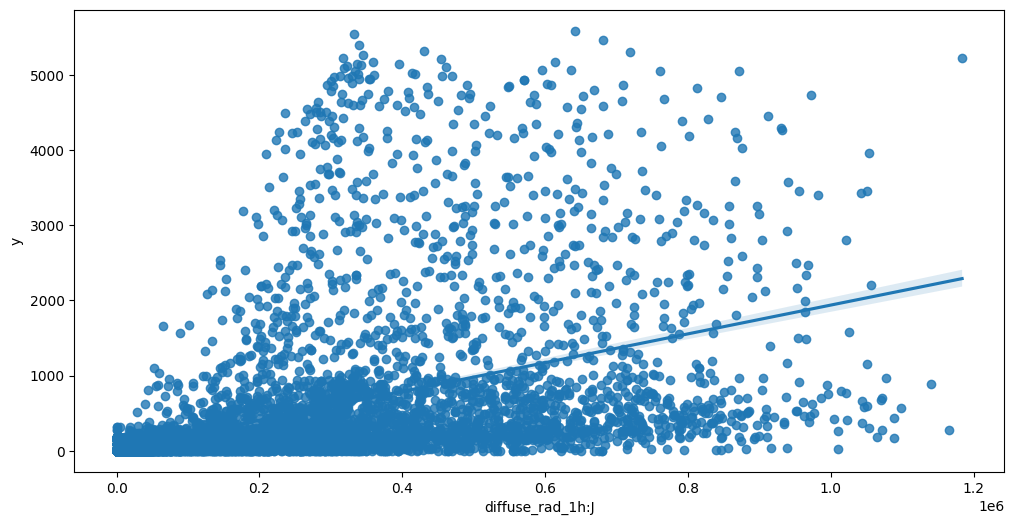

**Feature interaction between `direct_rad_1h:J`/`y` in `train_data` (sample size: 10000)**

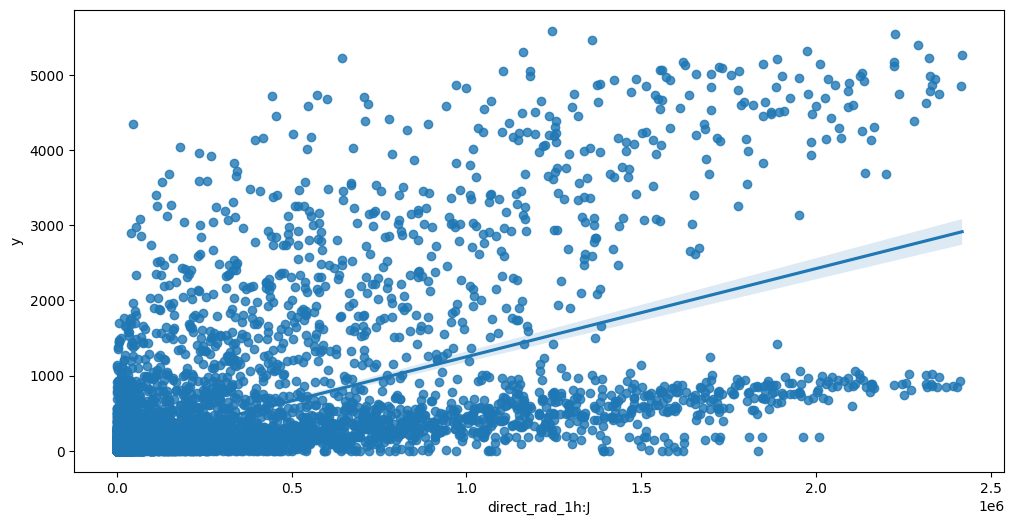

**Feature interaction between `direct_rad:W`/`y` in `train_data` (sample size: 10000)**

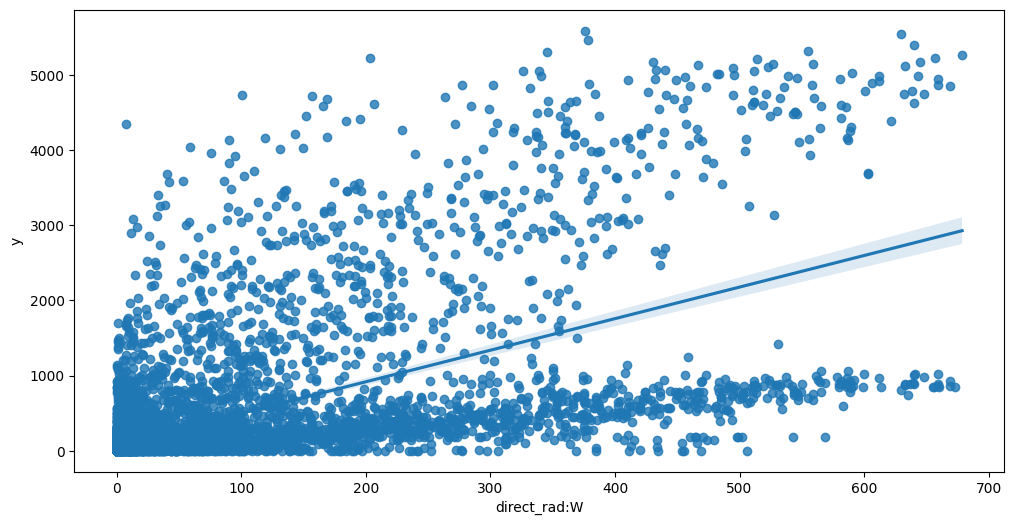

**Feature interaction between `sun_elevation:d`/`y` in `train_data` (sample size: 10000)**

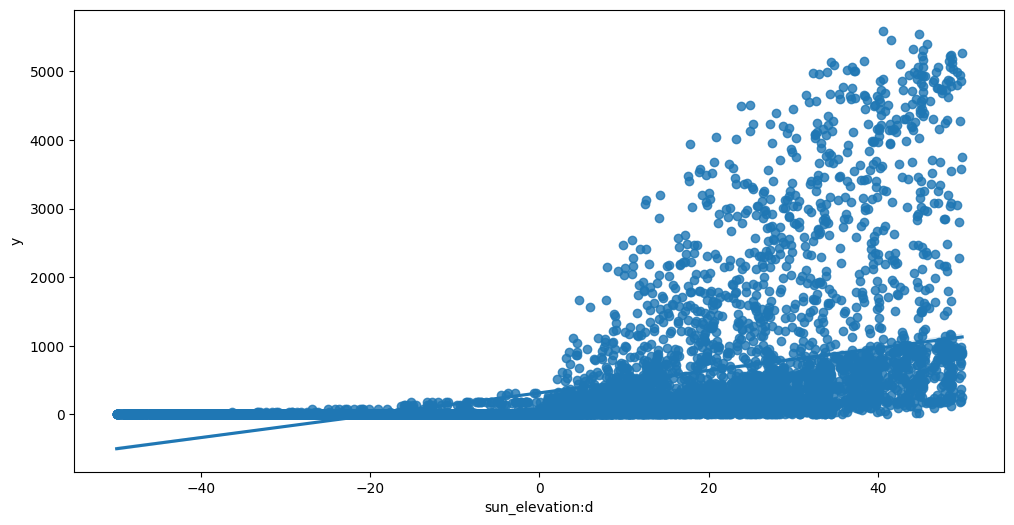

**Feature interaction between `is_day:idx`/`y` in `train_data` (sample size: 10000)**

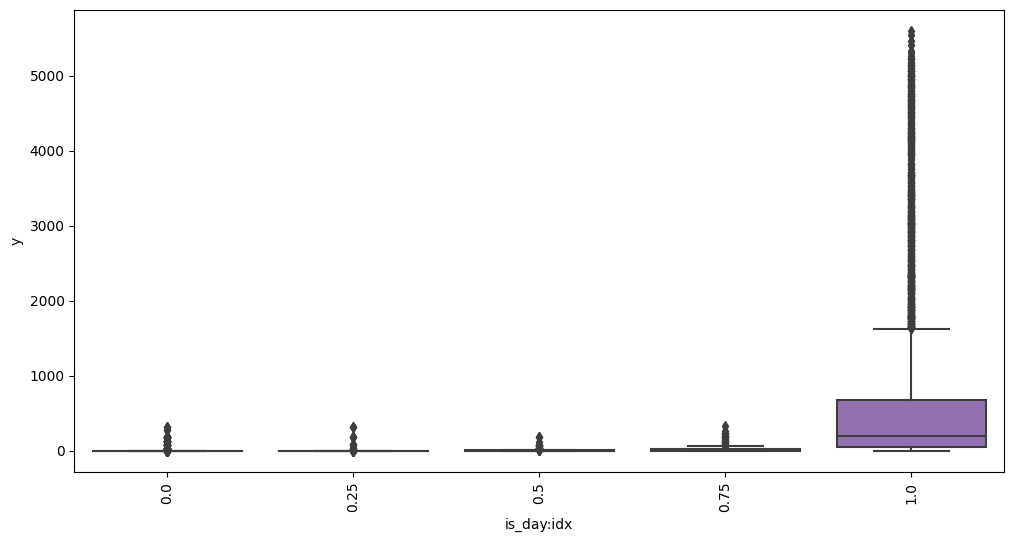

**Feature interaction between `is_in_shadow:idx`/`y` in `train_data` (sample size: 10000)**

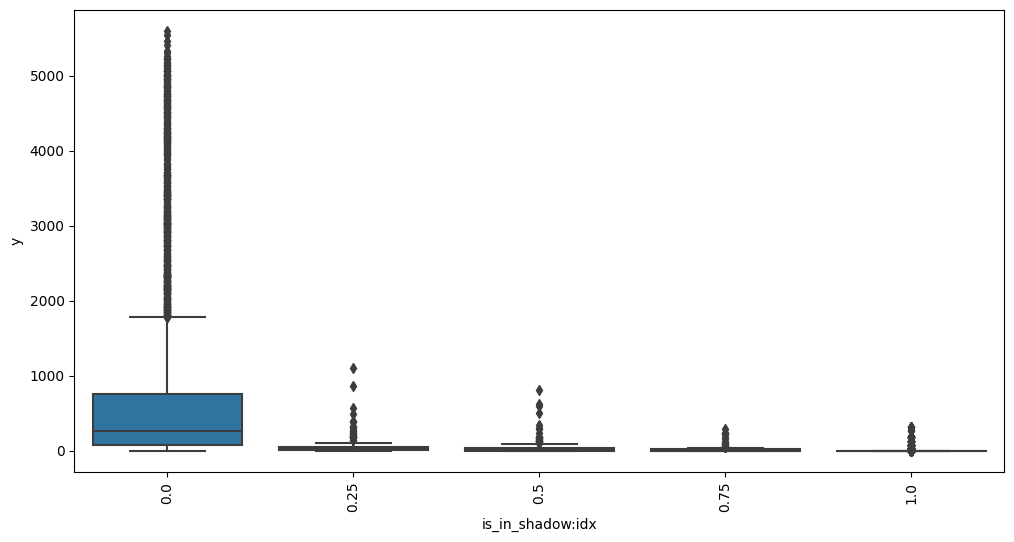

In [69]:
if run_analysis:
    auto.target_analysis(train_data=train_data, label="y")

# Starting

In [70]:
import os


# Get the last submission number
last_submission_number = int(max([int(filename.split('_')[1].split('.')[0]) for filename in os.listdir('submissions') if "submission" in filename]))
print("Last submission number:", last_submission_number)
print("Now creating submission number:", last_submission_number + 1)

# Create the new filename
new_filename = f'submission_{last_submission_number + 1}'

hello = os.environ.get('HELLO')
if hello is not None:
    new_filename += f'_{hello}'

print("New filename:", new_filename)

Last submission number: 81
Now creating submission number: 82
New filename: submission_82_jorge


In [71]:
predictors = [None, None, None]

In [74]:
def fit_predictor_for_location(loc):
    print(f"Training model for location {loc}...")
    # sum of sample weights for this location, and number of rows, for both train and tune data and test data
    print("Train data sample weight sum:", train_data[train_data["location"] == loc]["sample_weight"].sum())
    print("Train data number of rows:", train_data[train_data["location"] == loc].shape[0])
    if use_tune_data:
        print("Tune data sample weight sum:", tuning_data[tuning_data["location"] == loc]["sample_weight"].sum())
        print("Tune data number of rows:", tuning_data[tuning_data["location"] == loc].shape[0])
    if use_test_data:
        print("Test data sample weight sum:", test_data[test_data["location"] == loc]["sample_weight"].sum())
        print("Test data number of rows:", test_data[test_data["location"] == loc].shape[0])
    predictor = TabularPredictor(
        label=label, 
        eval_metric=metric, 
        path=f"AutogluonModels/{new_filename}_{loc}", 
        sample_weight=sample_weight, 
        weight_evaluation=weight_evaluation, 
        groups="group" if use_groups else None,
    ).fit(
        train_data=train_data[train_data["location"] == loc],
        time_limit=time_limit, 
        presets=presets, 
        num_stack_levels=num_stack_levels, 
        num_bag_folds=num_bag_folds if not use_groups else 2,# just put somethin, will be overwritten anyways
        tuning_data=tuning_data[tuning_data["location"] == loc] if use_tune_data else None,
        use_bag_holdout=use_bag_holdout,
        holdout_frac=holdout_frac,
    )

    # evaluate on test data
    if use_test_data:
        # drop sample_weight column
        t = test_data[test_data["location"] == loc]#.drop(columns=["sample_weight"])
        perf = predictor.evaluate(t)
        print("Evaluation on test data:")
        print(perf[predictor.eval_metric.name])

    return predictor

loc = "A"
predictors[0] = fit_predictor_for_location(loc)



Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/submission_82_jorge_A/"
AutoGluon Version:  0.8.1
Python Version:     3.10.12
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 22.1.0: Sun Oct  9 20:15:09 PDT 2022; root:xnu-8792.41.9~2/RELEASE_ARM64_T6000
Disk Space Avail:   12.28 GB / 494.38 GB (2.5%)
Train Data Rows:    31924
Train Data Columns: 46
Label Column: y
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (5733.42, 0.0, 632.68576, 1165.32372)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary

Training model for location A...
Train data sample weight sum: 31924
Train data number of rows: 31924
Test data sample weight sum: 2161
Test data number of rows: 2161


	-246.9432	 = Validation score   (-mean_absolute_error)
	0.03s	 = Training   runtime
	225.55s	 = Validation runtime
Fitting model: KNeighborsDist_BAG_L1 ... Training model for up to 170.55s of the 370.61s of remaining time.
	-247.6829	 = Validation score   (-mean_absolute_error)
	0.03s	 = Training   runtime
	312.38s	 = Validation runtime
Completed 1/20 k-fold bagging repeats ...
Fitting model: WeightedEnsemble_L2 ... Training model for up to 360.0s of the 54.86s of remaining time.
	-246.8492	 = Validation score   (-mean_absolute_error)
	0.14s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting 9 L2 models ...
Fitting model: LightGBMXT_BAG_L2 ... Training model for up to 54.71s of the 54.69s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy
2023-10-16 10:19:07,225	ERROR services.py:1169 -- Failed to start the dashboard , return code 1
2023-10-16 10:19:07,227	ERROR services.py:1194 -- Error should be written to 'dashboard.log' 

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /opt/homebrew/anaconda3/envs/ag/lib/python3.10/site-packages/autogluon/core/trainer/abstract_tra │
│ iner.py:1733 in _train_and_save                                                                  │
│                                                                                                  │
│   1730 │   │   │   │   logger.log(15, f"{len(X_pseudo)} extra rows of pseudolabeled data added   │
│   1731 │   │   │   │   model = self._train_single(X_w_pseudo, y_w_pseudo, model, X_val, y_val,   │
│   1732 │   │   │   else:                                                                         │
│ ❱ 1733 │   │   │   │   model = self._train_single(X, y, model, X_val, y_val, total_resources=to  │
│   1734 │   │   │                                                                                 │
│   1735 │   │   │   fit_end_time = time.time()                                                    │
│   1736 │   │   │   if self.weight_evaluation:                                                    │
│                                                                                                  │
│ /opt/homebrew/anaconda3/envs/ag/lib/python3.10/site-packages/autogluon/core/trainer/abstract_tra │
│ iner.py:1684 in _train_single                                                                    │
│                                                                                                  │
│   1681 │   │   Trains model but does not add the trained model to this Trainer.                  │
│   1682 │   │   Returns trained model object.                                                     │
│   1683 │   │   """                                                                               │
│ ❱ 1684 │   │   model = model.fit(X=X, y=y, X_val=X_val, y_val=y_val, total_resources=total_reso  │
│   1685 │   │   return model                                                                      │
│   1686 │                                                                                         │
│   1687 │   def _train_and_save(                                                                  │
│                                                                                                  │
│ /opt/homebrew/anaconda3/envs/ag/lib/python3.10/site-packages/autogluon/core/models/abstract/abst │
│ ract_model.py:829 in fit                                                                         │
│                                                                                                  │
│    826 │   │   self._register_fit_metadata(**kwargs)                                             │
│    827 │   │   self.validate_fit_resources(**kwargs)                                             │
│    828 │   │   self._validate_fit_memory_usage(**kwargs)                                         │
│ ❱  829 │   │   out = self._fit(**kwargs)                                                         │
│    830 │   │   if out is None:                                                                   │
│    831 │   │   │   out = self                                                                    │
│    832 │   │   out = out._post_fit(**kwargs)                                                     │
│                                                                                                  │
│ /opt/homebrew/anaconda3/envs/ag/lib/python3.10/site-packages/autogluon/core/models/ensemble/stac │
│ ker_ensemble_model.py:169 in _fit                                                                │
│                                                                                                  │
│   166 │   │   X = self.preprocess(X=X, preprocess_nonadaptive=False, fit=True, compute_base_pr   │
│   167 │   │   if time_limit is not None:                                                         │
│   168 │   │   │   time_limit = time_limit - (time.time() - 

In [73]:
loc = "B"
predictors[1] = fit_predictor_for_location(loc)

Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/submission_82_jorge_B/"
AutoGluon Version:  0.8.1
Python Version:     3.10.12
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 22.1.0: Sun Oct  9 20:15:09 PDT 2022; root:xnu-8792.41.9~2/RELEASE_ARM64_T6000
Disk Space Avail:   12.39 GB / 494.38 GB (2.5%)
Train Data Rows:    30792
Train Data Columns: 46
Label Column: y
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (1152.3, -0.0, 97.67477, 195.03642)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Ava

Training model for location B...
Train data sample weight sum: 30792
Train data number of rows: 30792
Test data sample weight sum: 2051
Test data number of rows: 2051


Automatically generating train/validation split with holdout_frac=0.0811899194595999, Train Rows: 28292, Val Rows: 2500
User-specified model hyperparameters to be fit:
{
	'NN_TORCH': {},
	'GBM': [{'extra_trees': True, 'ag_args': {'name_suffix': 'XT'}}, {}, 'GBMLarge'],
	'CAT': {},
	'XGB': {},
	'FASTAI': {},
	'RF': [{'criterion': 'gini', 'ag_args': {'name_suffix': 'Gini', 'problem_types': ['binary', 'multiclass']}}, {'criterion': 'entropy', 'ag_args': {'name_suffix': 'Entr', 'problem_types': ['binary', 'multiclass']}}, {'criterion': 'squared_error', 'ag_args': {'name_suffix': 'MSE', 'problem_types': ['regression', 'quantile']}}],
	'XT': [{'criterion': 'gini', 'ag_args': {'name_suffix': 'Gini', 'problem_types': ['binary', 'multiclass']}}, {'criterion': 'entropy', 'ag_args': {'name_suffix': 'Entr', 'problem_types': ['binary', 'multiclass']}}, {'criterion': 'squared_error', 'ag_args': {'name_suffix': 'MSE', 'problem_types': ['regression', 'quantile']}}],
	'KNN': [{'weights': 'uniform', 'ag

[1000]	valid_set's l1: 33.6299
[2000]	valid_set's l1: 31.3355
[3000]	valid_set's l1: 29.9595
[4000]	valid_set's l1: 29.1299
[5000]	valid_set's l1: 28.5605
[6000]	valid_set's l1: 28.1051
[7000]	valid_set's l1: 27.803
[8000]	valid_set's l1: 27.5098
[9000]	valid_set's l1: 27.2818
[10000]	valid_set's l1: 27.0998


	-27.0973	 = Validation score   (-mean_absolute_error)
	72.27s	 = Training   runtime
	0.43s	 = Validation runtime
Fitting model: LightGBM ... Training model for up to 468.34s of the 468.34s of remaining time.


[1000]	valid_set's l1: 32.0348
[2000]	valid_set's l1: 30.3776


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:2                                                                                    │
│                                                                                                  │
│   1 loc = "B"                                                                                    │
│ ❱ 2 predictors[1] = fit_predictor_for_location(loc)                                              │
│   3                                                                                              │
│                                                                                                  │
│ in fit_predictor_for_location:12                                                                 │
│                                                                                                  │
│    9 │   if use_test_data:                                                                       │
│   10 │   │   print("Test data sample weight sum:", test_data[test_data["location"] == loc]["s    │
│   11 │   │   print("Test data number of rows:", test_data[test_data["location"] == loc].shape    │
│ ❱ 12 │   predictor = TabularPredictor(                                                           │
│   13 │   │   label=label,                                                                        │
│   14 │   │   eval_metric=metric,                                                                 │
│   15 │   │   path=f"AutogluonModels/{new_filename}_{loc}",                                       │
│                                                                                                  │
│ /opt/homebrew/anaconda3/envs/ag/lib/python3.10/site-packages/autogluon/core/utils/decorators.py: │
│ 31 in _call                                                                                      │
│                                                                                                  │
│   28 │   │   @functools.wraps(f)                                                                 │
│   29 │   │   def _call(*args, **kwargs):                                                         │
│   30 │   │   │   gargs, gkwargs = g(*other_args, *args, **kwargs)                                │
│ ❱ 31 │   │   │   return f(*gargs, **gkwargs)                                                     │
│   32 │   │                                                                                       │
│   33 │   │   return _call                                                                        │
│   34                                                                                             │
│                                                                                                  │
│ /opt/homebrew/anaconda3/envs/ag/lib/python3.10/site-packages/autogluon/tabular/predictor/predict │
│ or.py:986 in fit                                                                                 │
│                                                                                                  │
│    983 │   │   if fit_weighted_ensemble is False:                                                │
│    984 │   │   │   aux_kwargs["fit_weighted_ensemble"] = False                                   │
│    985 │   │   self.save(silent=True)  # Save predictor to disk to enable prediction and traini  │
│ ❱  986 │   │   self._learner.fit(                                                                │
│    987 │   │   │   X=train_data,                                                                 │
│    988 │   │   │   X_val=tuning_data,                                                            │
│    989 │   │   │   X_unlabeled=unlabeled_data,                                                   │
│                                                                                                  │
│ /opt/homebrew/anaconda3/envs/ag/lib/python3.10/site-package

In [ ]:
loc = "C"
predictors[2] = fit_predictor_for_location(loc)

Values in column 'sample_weight' used as sample weights instead of predictive features. Evaluation will report weighted metrics, so ensure same column exists in test data.
Values in column 'group' used as split folds instead of being automatically set. Bagged models will have 8 splits.
Beginning AutoGluon training ... Time limit = 60s
AutoGluon will save models to "AutogluonModels/submission_94_jorge_C/"
AutoGluon Version:  0.8.1
Python Version:     3.10.12
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 22.1.0: Sun Oct  9 20:15:09 PDT 2022; root:xnu-8792.41.9~2/RELEASE_ARM64_T6000
Disk Space Avail:   1.41 GB / 494.38 GB (0.3%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Train Data Rows:    26071
Train Data Columns: 47
Label Column: y
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and label-values can't be converted to 

Training model for location C...
Train data sample weight sum: 26071
Train data number of rows: 26071
Test data sample weight sum: 1579
Test data number of rows: 1579


	Not enough time to generate out-of-fold predictions for model. Estimated time required was 153.54s compared to 51.89s of available time.
	Time limit exceeded... Skipping KNeighborsUnif_BAG_L1.
Fitting model: KNeighborsDist_BAG_L1 ... Training model for up to 36.94s of the 56.91s of remaining time.
	Not enough time to generate out-of-fold predictions for model. Estimated time required was 91.14s compared to 48.0s of available time.
	Time limit exceeded... Skipping KNeighborsDist_BAG_L1.
Fitting model: LightGBMXT_BAG_L1 ... Training model for up to 35.15s of the 55.12s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy
	-24.431	 = Validation score   (-mean_absolute_error)
	2.75s	 = Training   runtime
	0.43s	 = Validation runtime
Fitting model: LightGBM_BAG_L1 ... Training model for up to 30.05s of the 50.02s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy
	-24.9735	 = Validatio

Evaluation on test data:
-8.660441610357754


# Submit

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

train_data_with_dates = TabularDataset('X_train_raw.csv')
train_data_with_dates["ds"] = pd.to_datetime(train_data_with_dates["ds"])

test_data = TabularDataset('X_test_raw.csv')
test_data["ds"] = pd.to_datetime(test_data["ds"])
#test_data

Loaded data from: X_train_raw.csv | Columns = 49 / 49 | Rows = 92951 -> 92951
Loaded data from: X_test_raw.csv | Columns = 47 / 47 | Rows = 2160 -> 2160


In [ ]:
test_ids = TabularDataset('test.csv')
test_ids["time"] = pd.to_datetime(test_ids["time"])
# merge test_data with test_ids
test_data_merged = pd.merge(test_data, test_ids, how="inner", right_on=["time", "location"], left_on=["ds", "location"])

#test_data_merged

Loaded data from: test.csv | Columns = 4 / 4 | Rows = 2160 -> 2160


In [ ]:
# predict, grouped by location
predictions = []
location_map = {
    "A": 0,
    "B": 1,
    "C": 2
}
for loc, group in test_data.groupby('location'):
    i = location_map[loc]
    subset = test_data_merged[test_data_merged["location"] == loc].reset_index(drop=True)
    #print(subset)
    pred = predictors[i].predict(subset)
    subset["prediction"] = pred
    predictions.append(subset)

    # get past predictions
    past_pred = predictors[i].predict(train_data_with_dates[train_data_with_dates["location"] == loc])
    train_data_with_dates.loc[train_data_with_dates["location"] == loc, "prediction"] = past_pred
    

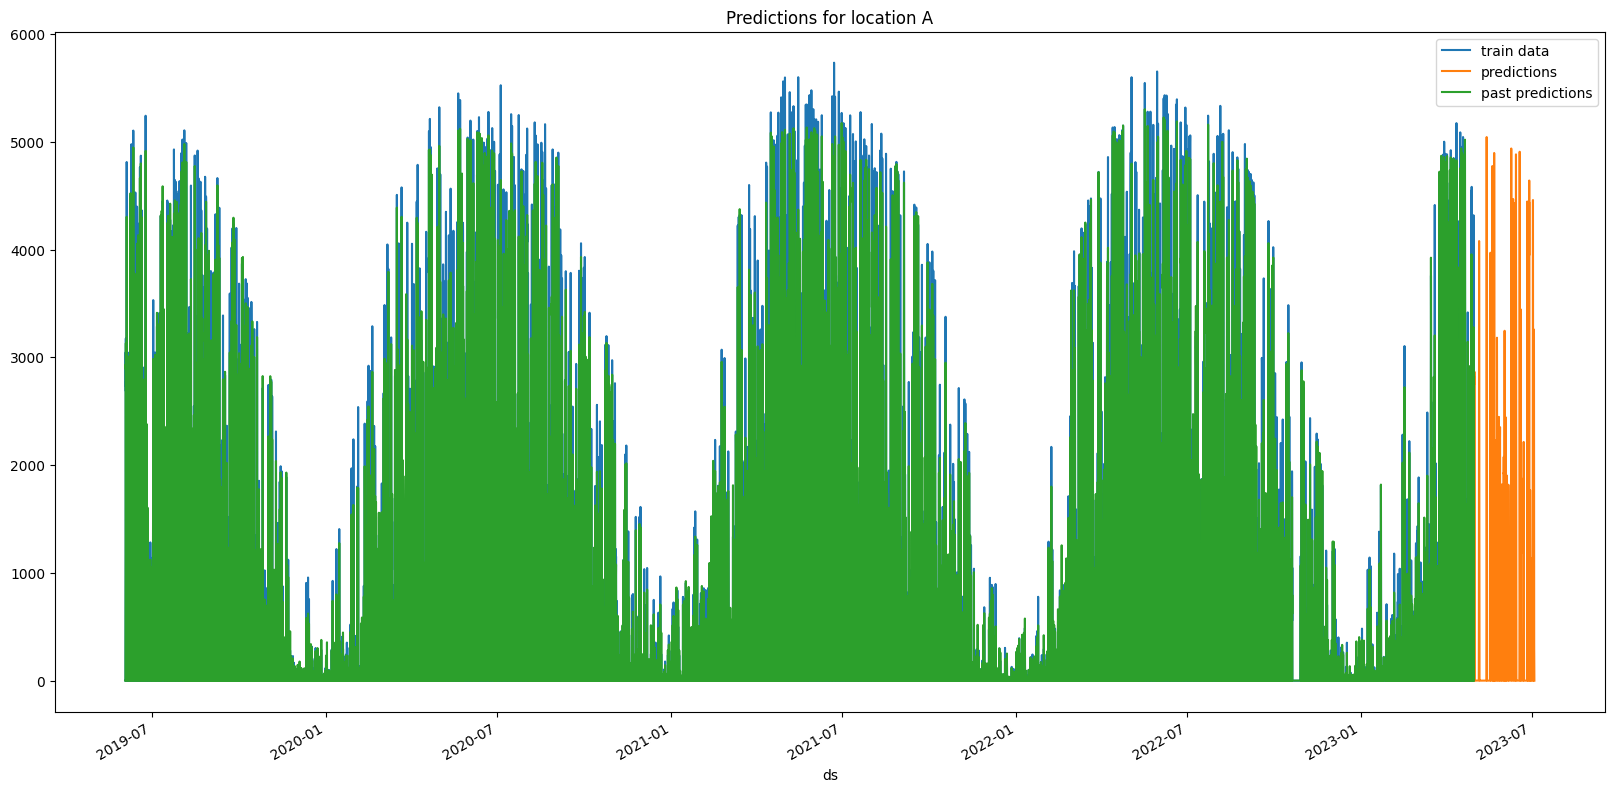

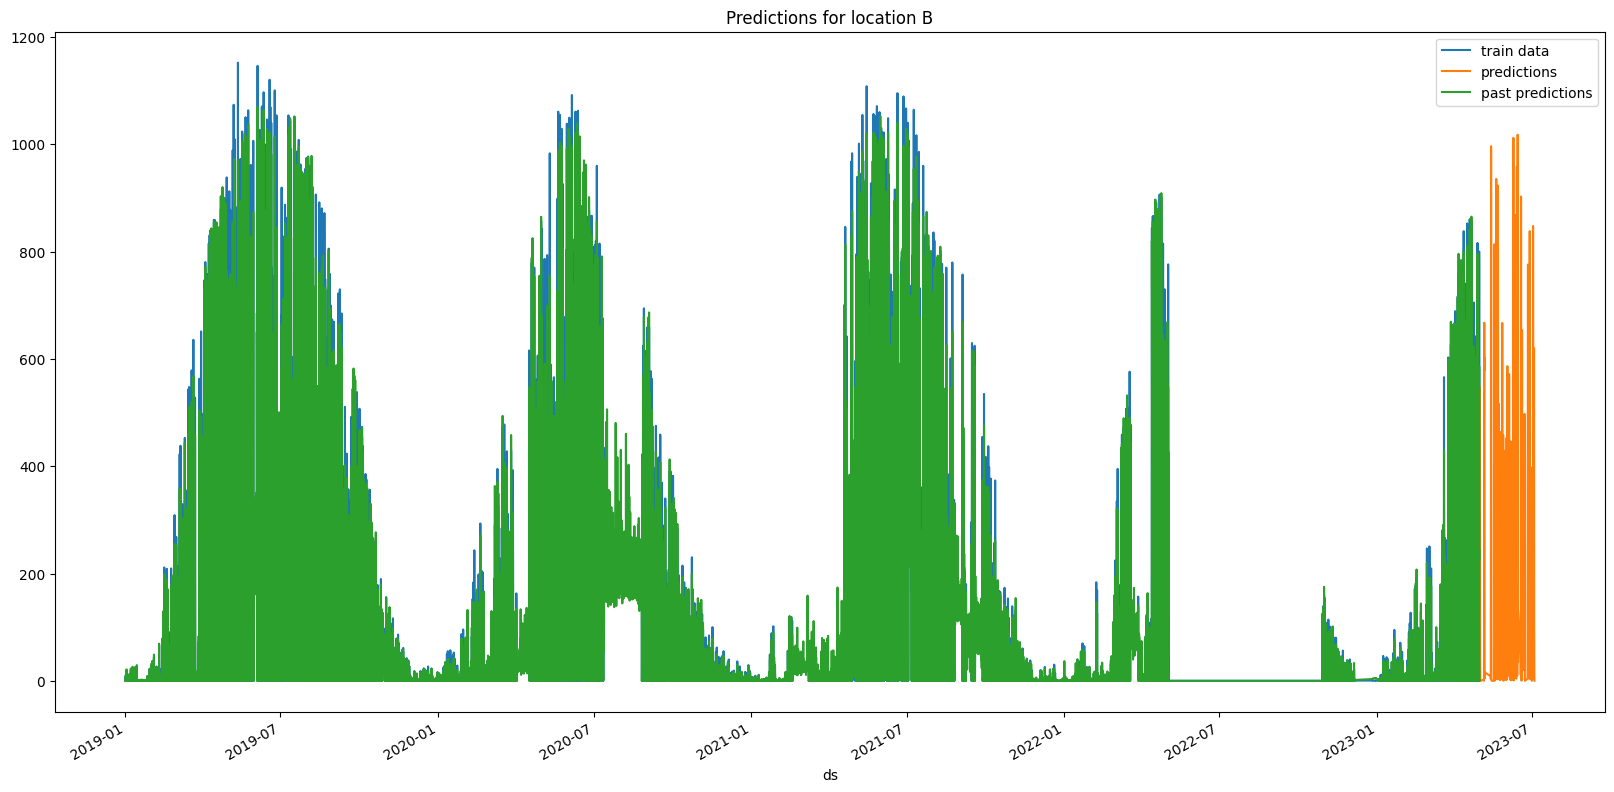

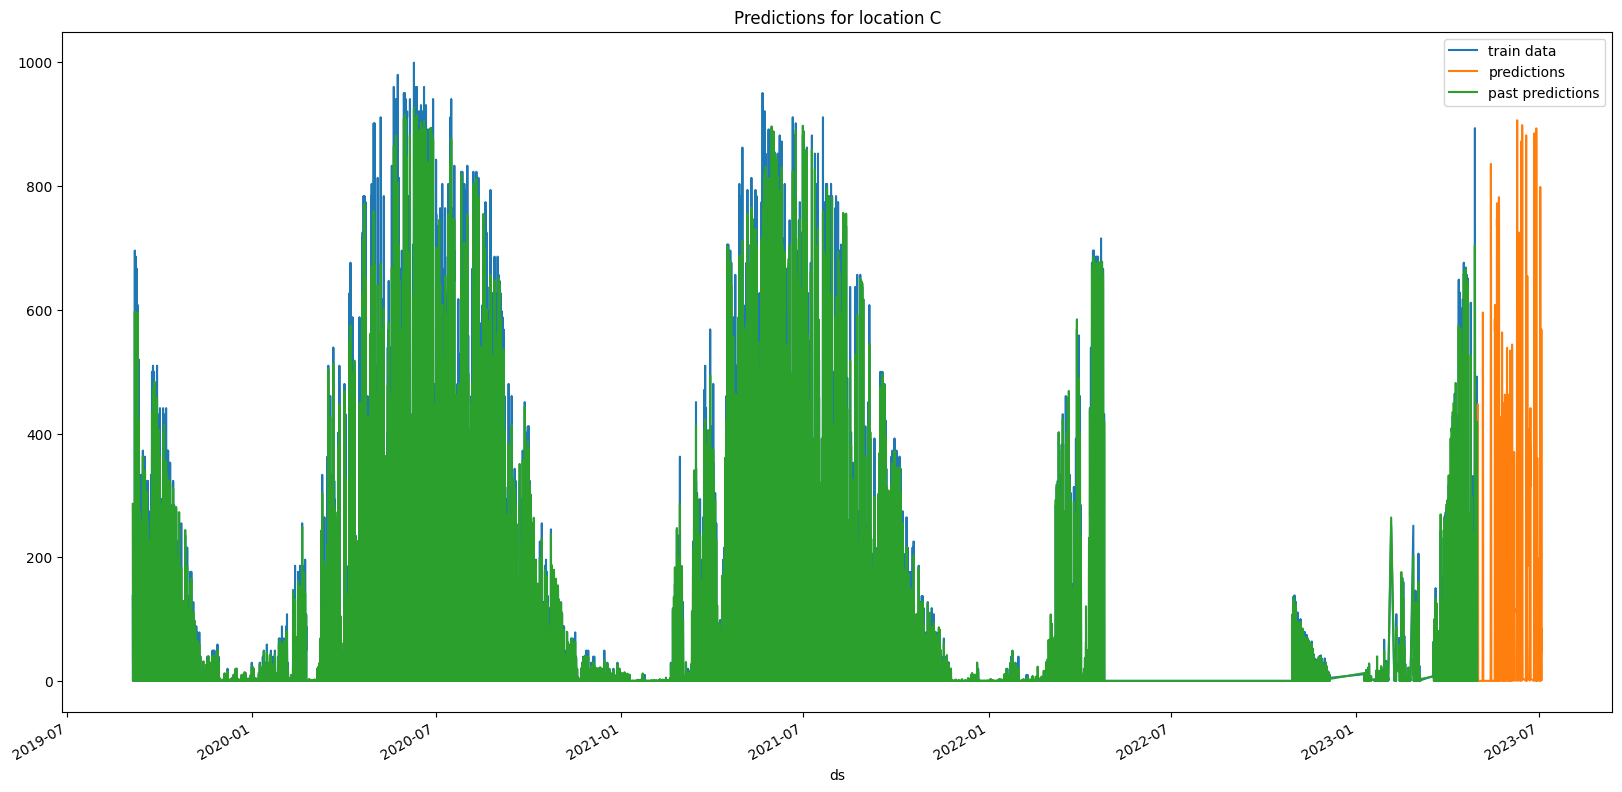

In [ ]:
# plot predictions for location A, in addition to train data for A
for loc, idx in location_map.items():
    fig, ax = plt.subplots(figsize=(20, 10))
    # plot train data
    train_data_with_dates[train_data_with_dates["location"]==loc].plot(x='ds', y='y', ax=ax, label="train data")

    # plot predictions
    predictions[idx].plot(x='ds', y='prediction', ax=ax, label="predictions")

    # plot past predictions
    train_data_with_dates[train_data_with_dates["location"]==loc].plot(x='ds', y='prediction', ax=ax, label="past predictions")

    # title
    ax.set_title(f"Predictions for location {loc}")

In [ ]:
# concatenate predictions
submissions_df = pd.concat(predictions)
submissions_df = submissions_df[["id", "prediction"]]
submissions_df

,id,prediction
0,0,0.675510
1,1,0.673196
2,2,0.836216
3,3,43.564392
4,4,289.932678
...,...,...
715,2155,84.286530
716,2156,57.080643
717,2157,27.658867
718,2158,4.312000


In [ ]:



# Save the submission DataFrame to submissions folder, create new name based on last submission, format is submission_<last_submission_number + 1>.csv

# Save the submission
print(f"Saving submission to submissions/{new_filename}.csv")
submissions_df.to_csv(os.path.join('submissions', f"{new_filename}.csv"), index=False)
print("jall1a")

Saving submission to submissions/submission_94_jorge.csv
jall1a


In [ ]:
# save this running notebook
from IPython.display import display, Javascript
import time

# hei123

display(Javascript("IPython.notebook.save_checkpoint();"))

time.sleep(3)

<IPython.core.display.Javascript object>

In [ ]:
# save this notebook to submissions folder
import subprocess
import os
subprocess.run(["jupyter", "nbconvert", "--to", "pdf", "--output", os.path.join('notebook_pdfs', f"{new_filename}.pdf"), "autogluon_each_location.ipynb"])

[NbConvertApp] Converting notebook autogluon_each_location.ipynb to pdf
[NbConvertApp] Support files will be in notebook_pdfs/submission_94_jorge_files/
[NbConvertApp] Making directory ./notebook_pdfs/submission_94_jorge_files/notebook_pdfs
[NbConvertApp] Writing 145400 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:4                                                                                    │
│                                                                                                  │
│   1 # save this notebook to submissions folder                                                   │
│   2 import subprocess                                                                            │
│   3 import os                                                                                    │
│ ❱ 4 subprocess.run(["jupyter", "nbconvert", "--to", "pdf", "--output", os.path.join('noteboo     │
│   5                                                                                              │
│                                                                                                  │
│ /opt/homebrew/anaconda3/envs/ag/lib/python3.10/subprocess.py:505 in run                          │
│                                                                                                  │
│    502 │                                                                                         │
│    503 │   with Popen(*popenargs, **kwargs) as process:                                          │
│    504 │   │   try:                                                                              │
│ ❱  505 │   │   │   stdout, stderr = process.communicate(input, timeout=timeout)                  │
│    506 │   │   except TimeoutExpired as exc:                                                     │
│    507 │   │   │   process.kill()                                                                │
│    508 │   │   │   if _mswindows:                                                                │
│                                                                                                  │
│ /opt/homebrew/anaconda3/envs/ag/lib/python3.10/subprocess.py:1146 in communicate                 │
│                                                                                                  │
│   1143 │   │   │   elif self.stderr:                                                             │
│   1144 │   │   │   │   stderr = self.stderr.read()                                               │
│   1145 │   │   │   │   self.stderr.close()                                                       │
│ ❱ 1146 │   │   │   self.wait()                                                                   │
│   1147 │   │   else:                                                                             │
│   1148 │   │   │   if timeout is not None:                                                       │
│   1149 │   │   │   │   endtime = _time() + timeout                                               │
│                                                                                                  │
│ /opt/homebrew/anaconda3/envs/ag/lib/python3.10/subprocess.py:1209 in wait                        │
│                                                                                                  │
│   1206 │   │   if timeout is not None:                                                           │
│   1207 │   │   │   endtime = _time() + timeout                                                   │
│   1208 │   │   try:                                                                              │
│ ❱ 1209 │   │   │   return self._wait(timeout=timeout)                                            │
│   1210 │   │   except KeyboardInterrupt:                                                         │
│   1211 │   │   │   # https://bugs.python.org/issue25942                                          │
│   1212 │   │   │   # The first keyboard interrupt waits briefly for the child to                 │
│                                                                                                  │
│ /opt/homebrew/anaconda3/envs/ag/lib/python3.10/subprocess.p

In [ ]:
# feature importance
location="A"
split_time = pd.Timestamp("2022-10-28 22:00:00")
estimated = train_data_with_dates[train_data_with_dates["ds"] >= split_time]
estimated = estimated[estimated["location"] == location]
predictors[0].feature_importance(feature_stage="original", data=estimated, time_limit=60*10)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:6                                                                                    │
│                                                                                                  │
│   3 split_time = pd.Timestamp("2022-10-28 22:00:00")                                             │
│   4 estimated = train_data_with_dates[train_data_with_dates["ds"] >= split_time]                 │
│   5 estimated = estimated[estimated["location"] == location]                                     │
│ ❱ 6 predictors[0].feature_importance(feature_stage="original", data=estimated, time_limit=60     │
│   7                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
AttributeError: 'NoneType' object has no attribute 'feature_importance'

In [ ]:
# feature importance
observed = train_data_with_dates[train_data_with_dates["ds"] < split_time]
observed = observed[observed["location"] == location]
predictors[0].feature_importance(feature_stage="original", data=observed, time_limit=60*10)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:4                                                                                    │
│                                                                                                  │
│   1 # feature importance                                                                         │
│   2 observed = train_data_with_dates[train_data_with_dates["ds"] < split_time]                   │
│   3 observed = observed[observed["location"] == location]                                        │
│ ❱ 4 predictors[0].feature_importance(feature_stage="original", data=observed, time_limit=60*     │
│   5                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
AttributeError: 'NoneType' object has no attribute 'feature_importance'

In [ ]:
display(Javascript("IPython.notebook.save_checkpoint();"))
time.sleep(3)

subprocess.run(["jupyter", "nbconvert", "--to", "pdf", "--output", os.path.join('notebook_pdfs', f"{new_filename}_with_feature_importance.pdf"), "autogluon_each_location.ipynb"])

<IPython.core.display.Javascript object>

[NbConvertApp] Converting notebook autogluon_each_location.ipynb to pdf
Traceback (most recent call last):
  File "/opt/homebrew/anaconda3/envs/ag/bin/jupyter-nbconvert", line 8, in <module>
    sys.exit(main())
  File "/opt/homebrew/anaconda3/envs/ag/lib/python3.10/site-packages/jupyter_core/application.py", line 282, in launch_instance
    super().launch_instance(argv=argv, **kwargs)
  File "/opt/homebrew/anaconda3/envs/ag/lib/python3.10/site-packages/traitlets/config/application.py", line 1053, in launch_instance
    app.start()
  File "/opt/homebrew/anaconda3/envs/ag/lib/python3.10/site-packages/nbconvert/nbconvertapp.py", line 412, in start
    self.convert_notebooks()
  File "/opt/homebrew/anaconda3/envs/ag/lib/python3.10/site-packages/nbconvert/nbconvertapp.py", line 590, in convert_notebooks
    self.convert_single_notebook(notebook_filename)
  File "/opt/homebrew/anaconda3/envs/ag/lib/python3.10/site-packages/nbconvert/nbconvertapp.py", line 556, in convert_single_notebook
   

CompletedProcess(args=['jupyter', 'nbconvert', '--to', 'pdf', '--output', 'notebook_pdfs/submission_94_jorge_with_feature_importance.pdf', 'autogluon_each_location.ipynb'], returncode=1)

In [ ]:
# import subprocess

# def execute_git_command(directory, command):
#     """Execute a Git command in the specified directory."""
#     try:
#         result = subprocess.check_output(['git', '-C', directory] + command, stderr=subprocess.STDOUT)
#         return result.decode('utf-8').strip(), True
#     except subprocess.CalledProcessError as e:
#         print(f"Git command failed with message: {e.output.decode('utf-8').strip()}")
#         return e.output.decode('utf-8').strip(), False

# git_repo_path = "."

# execute_git_command(git_repo_path, ['config', 'user.email', 'henrikskog01@gmail.com'])
# execute_git_command(git_repo_path, ['config', 'user.name', hello if hello is not None else 'Henrik eller Jørgen'])

# branch_name = new_filename

# # add datetime to branch name
# branch_name += f"_{pd.Timestamp.now().strftime('%Y-%m-%d_%H-%M-%S')}"

# commit_msg = "run result"

# execute_git_command(git_repo_path, ['checkout', '-b',branch_name])

# # Navigate to your repo and commit changes
# execute_git_command(git_repo_path, ['add', '.'])
# execute_git_command(git_repo_path, ['commit', '-m',commit_msg])

# # Push to remote
# output, success = execute_git_command(git_repo_path, ['push', 'origin',branch_name])

# # If the push fails, try setting an upstream branch and push again
# if not success and 'upstream' in output:
#     print("Attempting to set upstream and push again...")
#     execute_git_command(git_repo_path, ['push', '--set-upstream', 'origin',branch_name])
#     execute_git_command(git_repo_path, ['push', 'origin', 'henrik_branch'])

# execute_git_command(git_repo_path, ['checkout', 'main'])